In [ ]:
print(SHAPExplainer.__doc__)


None


None
shap_values shape: (200, 11, 2)
X_train shape: (4937, 11)
X_train.columns: ['Number_of_Priors', 'score_factor', 'Age_Above_FourtyFive', 'Age_Below_TwentyFive', 'African_American', 'Asian', 'Hispanic', 'Native_American', 'Other', 'Female', 'Misdemeanor']
Detected multiclass SHAP output; using class 1 SHAP values
SHAP values shape: (200, 11)
Features shape: (200, 11)


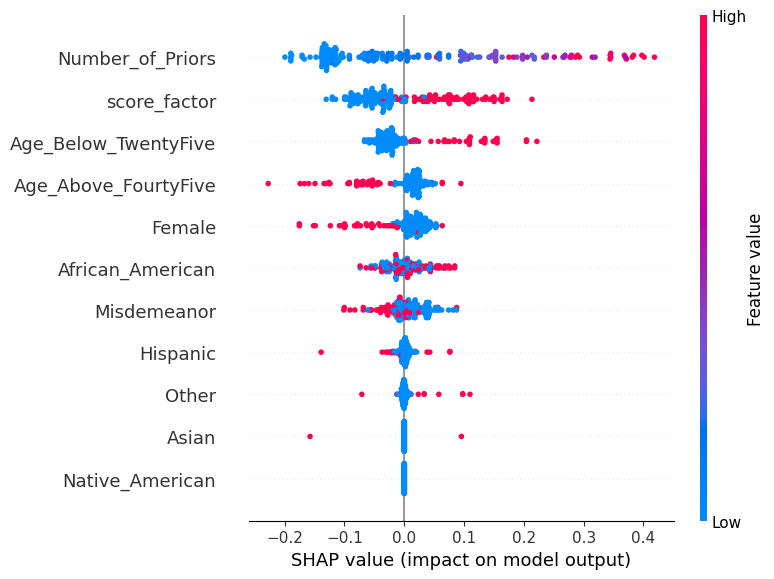

ValueError: The waterfall plot can currently only plot a single explanation, but a matrix of explanations (shape (11, 2)) was passed! Perhaps try `shap.plots.waterfall(shap_values[0])` or for multi-output models, try `shap.plots.waterfall(shap_values[0, 0])`.

In [4]:
import pandas as pd
import shap
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import sys
sys.path.append('..') 
from explainbench.shap_wrapper import SHAPExplainer
print(SHAPExplainer.__doc__)

# Load cleaned COMPAS dataset
df = pd.read_csv('../datasets/compas_clean.csv')
target = 'Two_yr_Recidivism'
X = df.drop(columns=[target])
y = df[target]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Initialize SHAP explainer
explainer = SHAPExplainer(model, X_train, model_type='tree')

# Compute SHAP values (global)
shap_values = explainer.explain_global(num_samples=200)

# DEBUG: check shapes before plotting
print("shap_values shape:", getattr(shap_values, 'values', shap_values).shape)
print("X_train shape:", X_train.shape)
print("X_train.columns:", X_train.columns.tolist())

# Plot SHAP summary
sample = X_train.sample(n=200, random_state=42)
shap_values = explainer.explain_global(num_samples=200)
explainer.plot_summary(shap_values, features=sample)

# Explain one instance
instance = X_test.iloc[0]
instance_shap = explainer.explain_instance(instance)
shap.plots.waterfall(instance_shap)


In [7]:
def explain_and_plot_instance(self, instance: pd.Series, class_idx: int = 1):
    explanation = self.explain_instance(instance)
    if explanation.values.ndim == 2:  # multiclass
        explanation = explanation[0, class_idx]
    else:
        explanation = explanation[0]
    shap.plots.waterfall(explanation)


For fairness analysis

In [ ]:
import pandas as pd
import shap
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from explainbench.shap_wrapper import SHAPExplainer

# Load COMPAS dataset (assumed to be cleaned)
df = pd.read_csv('../datasets/compas_clean.csv')

# Preprocess data
target = 'two_year_recid'
categorical = ['sex', 'race', 'age_cat', 'c_charge_degree']

for col in categorical:
    df[col] = LabelEncoder().fit_transform(df[col])

X = df.drop(columns=[target])
y = df[target]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predictions for fairness analysis
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]
X_test['pred'] = y_pred
X_test['actual'] = y_test.values
X_test['prob'] = y_prob
X_test['race'] = df.loc[X_test.index, 'race']
X_test['sex'] = df.loc[X_test.index, 'sex']

# Accuracy by group
def group_accuracy(df, group_col):
    return df.groupby(group_col).apply(lambda x: accuracy_score(x['actual'], x['pred'])).rename('accuracy')

print("Accuracy by race:")
print(group_accuracy(X_test, 'race'))

print("Accuracy by sex:")
print(group_accuracy(X_test, 'sex'))

# Disparate impact ratio
def disparate_impact(df, protected_col, privileged_val):
    favorable = df['pred'] == 0
    groups = df.groupby(protected_col)
    prob_priv = (groups.get_group(privileged_val)['pred'] == 0).mean()
    ratios = {}
    for group, group_df in groups:
        if group != privileged_val:
            prob_group = (group_df['pred'] == 0).mean()
            ratios[group] = round(prob_group / prob_priv, 3)
    return ratios

print("Disparate impact by race (privileged=0):")
print(disparate_impact(X_test, 'race', 0))

print("Disparate impact by sex (privileged=0):")
print(disparate_impact(X_test, 'sex', 0))

# SHAP explanations
explainer = SHAPExplainer(model, X_train, model_type='tree')
shap_values = explainer.explain_global(num_samples=200)
explainer.plot_summary(shap_values, features=X_train)

# Waterfall for an example
instance = X_test.drop(columns=['pred', 'actual', 'prob', 'race', 'sex']).iloc[0]
instance_shap = explainer.explain_instance(instance)
shap.plots.waterfall(instance_shap[0])

# Save global summary plot
plt.figure()
shap.summary_plot(shap_values.values, X_train, show=False)
plt.tight_layout()
plt.savefig('shap_summary_plot.png')

# Group-wise feature importance (mean SHAP)
def group_shap_means(df, shap_values, group_col):
    df_temp = df.copy()
    df_temp[group_col] = df[group_col]
    df_temp_shap = pd.DataFrame(shap_values.values, columns=df.columns)
    df_temp_shap[group_col] = df_temp[group_col].values
    return df_temp_shap.groupby(group_col).mean()

race_importance = group_shap_means(X_train, shap_values, 'race')
race_importance.T.plot(kind='bar', figsize=(10, 6))
plt.title('Mean SHAP Values by Race')
plt.ylabel('Mean SHAP Value')
plt.tight_layout()
plt.savefig('shap_race_comparison.png')
